# __XOR-net__

Minimal (2 layer, 3 node, 9 parameter) multi-layer perceptron that learns the
notorious XOR function, with some background and analysis.

This neural network is implemented entirely in vanilla Python (without
numpy/pytorch/tensorflow/scikit-learn) for educational purposes. A side effect
is that this may be the most inefficient implementation of XOR in the history
of computer science. 🥇

Author: Jeremy Dolan

In [1]:
import math
import random
from typing import List, Callable, TypedDict
import plots.xor_net # illustrations for this notebook

## Background: XOR

XOR ("exclusive or") is a binary Boolean function; it maps 2 truth value
inputs (by convention: $0$ for false, $1$ for true) to one truth value output:

$$f : \{0,1\}^2 → \{0,1\}$$

The _input space_ for a binary Boolean function consists of 2 inputs with 2
possible values, giving us $2^2 = 4$ points: $(0,0)$, $(0,1)$, $(1,0)$, and
$(1,1)$. Each of those $2^2$ input pairs can independently map to 2 possible
output values, for a total of $2^{2^2} = 16$ possible functions. XOR is the
name we give to the function that maps points $(0,1)$ and $(1,0)$ to $1$, and
points $(0,0)$ and $(1,1)$ to $0$. It means, roughly: "One or the other, _but
not both_."

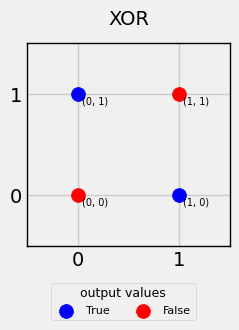

In [2]:
plots.xor_net.plot_binary_Boolean_input_space_with_XOR_output()

## Background: Linear separability

As Minsky and Papert (1969) infamously argued, a single layer neural network
can only be made to fit linearly separable data: that is, data for which a
single, straight line can separate two classes of interest. For example, "OR"
(inclusive or) is linearly separable: it is true for three of the four points
in our Boolean input space, and we can draw a straight line "decision boundary"
which separates these three points from the one point where it is false (see
"OR classification," below left).

XOR, however, is _not_ linearly separable. There is no line you can draw that
will partition the input space in such a way as to separate the input points
that map to true—$(0,1)$ and $(1,0)$—from the input points that map to
false—$(0,0)$ and $(1,1)$ (see below right).

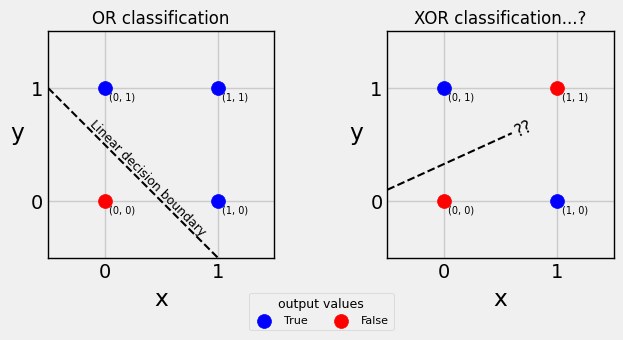

In [3]:
plots.xor_net.plot_linear_separation_OR_vs_XOR()

Minsky and Papert were correct that a *single-layer* neural network cannot
learn the XOR function, or any other linearly-inseparable function, no matter
how many nodes and connections it may have, or how we configure and train those
nodes and connections. With neither the computational power nor feasible
training techniques for *multi-layer* networks in sight, they argued that this
was a fundamental limitation for the connectionist approach to AI, relegating
neural networks to solving only toy problems, with no hope of scaling to
general purpose learning.[^1]

[^1]: Many commentators now credit Minsky and Papert's criticisms with playing
a large role in the shift away from neural network research (and a decline in
funding for AI in general) in the 1970s and early 1980s, although it seems this
causal claim is largely mythologized (see Olazaran (1996) "[A Sociological
Study of the Official History of the Perceptrons Controversy][1]"; and Liu
(2024) "[The Perceptron Controversy][2]").

[1]: https://journals.sagepub.com/doi/abs/10.1177/030631296026003005
[2]: https://yuxi-liu-wired.github.io/essays/posts/perceptron-controversy/#ref-olazaranHistoricalSociologyNeural1991

Thanks to Moore's Law, and the successful application of backpropagation and
gradient descent for training, modern neural networks are no longer limited to
a single layer, and can be hundreds of layers deep. But how does adding
additional layers allow an architecturally-simple feed-forward network to do
what a single layer cannot, namely, create non-linear decision boundaries in
order to model linearly-inseparable functions.

When a second layer is added, a linearly-inseparable problem can be broken into
linearly-separable steps. To help visualize this, we can construct a two-layer
network, and analyze how it learns XOR.


# Neural network framework

### Activation functions, loss functions, and derivatives

In [4]:
def ReLU(z:float):
    '''rectified linear unit function, aka squash at zero'''
    return max(0, z)

def sigmoid(z:float):
    '''sigmoid function for binary classification'''
    exp_z = math.exp(z)          # benchmark: 10-14% faster to store exp(z) rather than calculate twice
    return exp_z / (1 + exp_z)   # alternate form for numerical stability; 1/(1+math.exp(-z)) will overflow

def log_loss(y:float, y_predicted:float):
    '''cross-entropy loss for binary classification; penalizes confident but incorrect predictions more heavily'''
    y_predicted = max(1e-15, min(1-1e-15, y_predicted))                   # clip ŷ to [1e-15, 1-1e15] to avoid log(0)
    return -( (y*math.log(y_predicted)) + (1-y)*math.log(1-y_predicted) ) # simplifies when y ∈ {0,1}

# derivatives of our activation and loss functions, for backpropagation:
def ReLU_derivative(v):
    return 1 if v > 0 else 0

def sigmoid_derivative(z):
    sig = sigmoid(z)
    return sig * (1-sig)

def sigmoid_derivative_from_a(a):
    return a * (1-a)

def log_loss_derivative(y_actual:float, y_predicted:float):
    y_predicted = max(1e-15, min(1-1e-15, y_predicted))           # clip ŷ to [1e-15, 1-1e15] to avoid dividing by 0
    return -(y_actual/y_predicted)+((1-y_actual)/(1-y_predicted))

# mappings
derivative_from_a = {
    ReLU: ReLU_derivative,
    sigmoid: sigmoid_derivative_from_a,
}
loss_derivative = {
    log_loss: log_loss_derivative,
}

Since we are working with binary values and, in effect, modeling Boolean
algebra, sigmoid is a natural choice for the activation function throughout our
network. Sigmoid squashes its input between 0 and 1, and we can interpret its
proximity to 0 or 1 as corresponding to the probability of the input belonging
to the false (0) or true (1) class, which are the only values relevant when
modeling a Boolean function.
 
Likewise, log loss is a natural choice for the loss function on our network's
output, as it is designed for probabilistic outputs of a binary classification
— which is what our sigmoid activation function will produce.

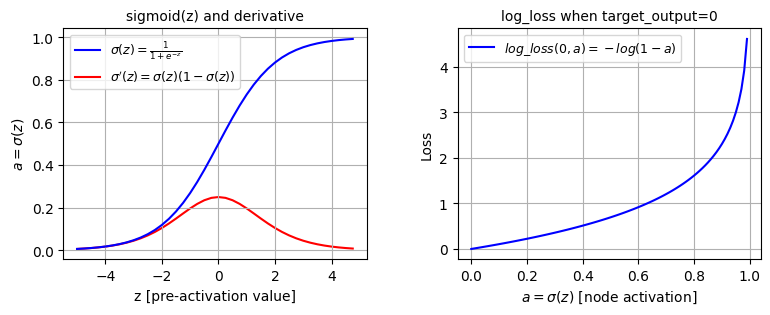

In [5]:
plots.xor_net.plot_functions(sigmoid, sigmoid_derivative, log_loss)

### Node, Layer, and Net classes

These three classes constitute an entire neural net framework with forward
inference (`Net.forward`), backward propagation (`Net.backward`), and batch
gradient descent training (`Net.batch_train`). The object oriented approach
makes the structure of the network more transparent, at the cost of obscuring
some of the math (in that the weights and biases are maintained within the Node
objects, rather than directly passed between the computing functions as in a
more procedural approach).

In [6]:
class Node:
    def __init__(self, L_index, N_index, in_nodes:int, activation_fx:Callable, bias:float = 0.):
        self.layer = L_index    # debugging convenience
        self.node = N_index     # debugging convenience
        self.bias = bias
        self.weights = [random.uniform(-0.2, 0.2) for _ in range(in_nodes)]
        self.activation_fx = activation_fx

    def activate(self, inputs:list):
        '''Sum the bias and dot product, apply the node's activation function.'''
        a = self.bias
        for weight, input_signal in zip(self.weights, inputs):
            a += weight*input_signal
        return self.activation_fx(a)


class Layer:
    def __init__(self, L_index, in_nodes:int, nodes:int, activation_fx:Callable):
        '''Construct a layer of `nodes` nodes, each with `in_nodes` weights and `activation_fx` activation function'''
        self.nodes = [Node(L_index, N_index, in_nodes, activation_fx) for N_index in range(nodes)]

    def activate(self, input:list):
        '''Activate each node in the layer, returning a list of activation values'''
        return [node.activate(input) for node in self.nodes]
    

class Net:
    def __init__(self, inputs:int, shape:List[int], activation_fxs:List[Callable], loss_fx:Callable):
        '''Construct a deep net with `inputs` input nodes and `loss_fx` as the loss function for training, where
        layer `n` has `shape[n]` nodes and `activation_fxs[n]` activation function.'''
        self.loss_fx = loss_fx
        assert len(shape) == len(activation_fxs)
        shape.insert(0, inputs)
        self.layers = [Layer(i, shape[i], shape[i+1], activation_fxs[i]) for i in range(len(shape)-1)]

    def show_params(self):
        '''Print the network's parameters (weights and biases of each node)'''
        for i,l in enumerate(self.layers):
            for j,n in enumerate(l.nodes):
                print(f'layer {i+1}, node {j+1}, {n.weights=} {n.bias=}')

    def forward(self, x:List[float]) -> List[List[float]]:
        '''Given input `x`, compute activations for each node in the network by iterating through layers'''
        return [x := layer.activate(x) for layer in self.layers]

    class Gradients(TypedDict):
        weight: List[List[List[float]]]
        bias: List[List[float]]
    def backward(self, x:list, y:float, activations:List[list]) -> Gradients:
        '''Compute partial derivatives ("gradients") of the loss w.r.t. every weight and bias, given the input `x`,
        the correct output `y`, and the `activations` from a forward pass. (The gradients indicate how a change to a
        weight or bias--while holding the other parameters fixed--would change the loss, and are what we'll use to train)'''
        # the prediction is just the final layer's output
        ŷ = activations[-1][0]
        # we don't need the actual loss, only the derivative of the loss
        dLdŷ = loss_derivative[self.loss_fx](y, ŷ)

        # create weight and bias gradient lists so we can index on them
        weight_grads = [[] for _ in range(len(self.layers))]
        bias_grads = [[] for _ in range(len(self.layers))]
        # initialize node gradient values to zero so we can accumulate on them
        node_grads = [[0] * len(self.layers[i].nodes) for i in range(len(self.layers))]
        # base case: derivative of the loss relative to our prediction
        node_grads[-1] = [dLdŷ]

        # iterate backwards through the layers
        for i in range(len(self.layers)-1, -1, -1):
            # for each node, its activation from the forward pass, and its gradient from the backward pass...
            for n, a, dLda in zip(self.layers[i].nodes, activations[i], node_grads[i]):
                # compute da/dz (partial derivative of the node's activation w.r.t. the pre-activation value)
                dadz = derivative_from_a[n.activation_fx](a)
                # compute dL/dz using the chain rule
                dLdz = dadz * dLda

                # Now distribute dLdz backwards to each component of z: bias, weights, and prior layer activations

                ### bias gradient ###
                # Since b is directly added into z, dz/db = 1, so by the chain rule, dL/db = 1 * dL/dz = dL/dz:
                bias_grads[i].append(dLdz)

                ### weight gradients ###
                # Since the weights scale an incoming signal (either an activation from the prior layer or an input),
                # the derivative of z w.r.t. the weight is just the value of that signal: dz/dw[j] = (a[i-1][j] or x[j])
                # Then, by the chain rule: dL/dw[j] = dz/dw[j] * dL/dz
                in_values = activations[i-1] if i != 0 else x
                weight_grads[i].append([dzdw * dLdz for dzdw in in_values])

                ### prior layer activation gradients ###
                # Likewise, the derivative of z w.r.t. the prior activation is just the weight: dz/da[i-1][j] = w[j]
                # However, because each node's activation can affect the loss via multiple downstream nodes, we must
                # accumulate all of these local effects to get the derivative of the loss: dL/da[i] += dz/da * dL/dz
                if i == 0:
                    # don't calculate gradients for the input (x); skip to the next node
                    continue
                for j in range(len(n.weights)):
                    dzda = n.weights[j]
                    dLda_increment = dzda * dLdz
                    node_grads[i-1][j] += dLda_increment
                    # print(f'added {dLda_increment} to node grad[{i-1}][{j}]')

        return {'weight': weight_grads, 'bias': bias_grads}

    # Last but not least, our training function. Since the training data is small, we can do full batch training
    def batch_train(self, training_data:List[dict], epochs:int, learning_rate:float=0.1):
        '''Train network using batch gradient descent with `training_data` for `epochs` batches'''
        def checkpoint(epoch):
            return True if epoch == 0 or (epoch+1) % 1_000 == 0 else False
        
        batch_loss = []
        for epoch in range(epochs):
            batch = []
            # (1) collect gradients for each case in the training data using a forward and backward pass for each
            for training_case in random.sample(training_data, len(training_data)):
                x, y = training_case.values()
                activations = self.forward(x)
                gradients = self.backward(x, y, activations)

                batch.append(gradients)
                if checkpoint(epoch):
                    ŷ = activations[-1][0]
                    batch_loss.append(self.loss_fx(y, ŷ))

            if checkpoint(epoch):
                print(f'epoch {epoch+1:{len(str(epochs))}d} loss={sum(batch_loss)/len(batch)}')
                batch_loss = []

            # (2) compute the average gradient for each weight and bias across all training cases in the batch
            average_bias_grad = [[] for _ in range(len(self.layers))]
            average_weight_grads = [[] for _ in range(len(self.layers))]
            for layer in range(len(self.layers)):
                transposed_bias_grads = list(zip(*[batch[b]['bias'][layer] for b in range(len(batch))]))
                average_bias_grad[layer] = [sum(grads)/len(batch) for grads in transposed_bias_grads]

                average_weight_grads[layer] = [[] for _ in range(len(self.layers[layer].nodes))]
                for node in range(len(self.layers[layer].nodes)):
                    transposed_weight_grads = list(zip(*[batch[b]['weight'][layer][node] for b in range(len(batch))]))
                    average_weight_grads[layer][node] = [sum(grads)/len(batch) for grads in transposed_weight_grads]

            # (3) nudge the weights in the direction opposite the gradient (which points towards the steepest ascent of loss)
            for layer, layer_b_grads, layer_w_grads in zip(self.layers, average_bias_grad, average_weight_grads):
                for node, b_grad, w_grads in zip(layer.nodes, layer_b_grads, layer_w_grads):
                    node.bias += -b_grad * learning_rate
                    for i in range(len(node.weights)):
                        node.weights[i] += -w_grads[i] * learning_rate

# XOR-net implementation
### Initialization
Initialize a network with the bare minimum depth (two layers) and breadth (two
hidden nodes, one output node) to implement XOR.

In [7]:
xor_net = Net(inputs=2, shape=[2, 1], activation_fxs=[sigmoid]*2, loss_fx=log_loss)
xor_net.show_params()

layer 1, node 1, n.weights=[-0.1857813838902963, -0.17648638292355093] n.bias=0.0
layer 1, node 2, n.weights=[-0.18344088626239136, 0.19806781739699036] n.bias=0.0
layer 2, node 1, n.weights=[0.09527414086635527, -0.05440077655547643] n.bias=0.0


### Training

Our training data is simply the XOR function, mapping two Boolean inputs to one Boolean output:

In [8]:
xor_training = (
    # input x, output y
    {'x': (0,0), 'y': (0)},
    {'x': (1,0), 'y': (1)},
    {'x': (0,1), 'y': (1)},
    {'x': (1,1), 'y': (0)},
)

Now we can train the network, using batch gradient decent:

In [9]:
# relatively high learning rate helps get us off initial plateau
xor_net.batch_train(training_data=xor_training, epochs=10_000, learning_rate=1.75)
xor_net.show_params()

epoch     1 loss=0.6931894394630645
epoch  1000 loss=0.6931451149133714
epoch  2000 loss=0.6931151378349951
epoch  3000 loss=0.016451819890830457
epoch  4000 loss=0.004070867840674805
epoch  5000 loss=0.0023040166361343807
epoch  6000 loss=0.0016036558638021048
epoch  7000 loss=0.0012288515955045673
epoch  8000 loss=0.000995638713162375
epoch  9000 loss=0.0008366136839143791
epoch 10000 loss=0.0007212717509454038
layer 1, node 1, n.weights=[-7.5899176214514075, 7.3081125984000845] n.bias=-3.8419129086108477
layer 1, node 2, n.weights=[-7.876398563483936, 8.09001686076555] n.bias=3.938839683279456
layer 2, node 1, n.weights=[15.727602048123943, -15.145779701726742] n.bias=7.244509250457777


### Prediction

In [10]:
for xor_case in xor_training:
    x, y = xor_case.values()            # x input, y_actual
    ŷ = xor_net.forward(x)[-1][0]       # y_predicted
    emoji = '\u2705' if y == round(ŷ) else '\u274C'
    print(f'{x[0]} XOR {x[1]} -> {round(ŷ)} {emoji} (prediction: {ŷ:5f}, loss: {log_loss(y, ŷ):5f})')

0 XOR 0 -> 0 ✅ (prediction: 0.000688, loss: 0.000688)
1 XOR 0 -> 1 ✅ (prediction: 0.999047, loss: 0.000953)
0 XOR 1 -> 1 ✅ (prediction: 0.999358, loss: 0.000642)
1 XOR 1 -> 0 ✅ (prediction: 0.000601, loss: 0.000601)


## Visualizing the learned decision boundary of our trained network

...

In [8]:
# use finite difference approximation to check our gradient algorithms:
e = 0.0001

# Layer 1 Node 1:
l1n1a = sigmoid(x[0] * xor_net.layers[0].nodes[0].weights[0] + \
                x[1] * xor_net.layers[0].nodes[0].weights[1] + \
                       xor_net.layers[0].nodes[0].bias)
# Layer 1 Node 2:
l1n2a = sigmoid(x[0] * xor_net.layers[0].nodes[1].weights[0] + \
                x[1] * xor_net.layers[0].nodes[1].weights[1] + \
                       xor_net.layers[0].nodes[1].bias)
# Layer 2 Node 1 (output node):
y_hat = sigmoid(l1n1a * xor_net.layers[1].nodes[0].weights[0] + \
                l1n2a * xor_net.layers[1].nodes[0].weights[1] + \
                        xor_net.layers[1].nodes[0].bias)
loss = log_loss(y, y_hat)


# introduce a difference to some one term:
l1n1a = sigmoid(x[0] * (xor_net.layers[0].nodes[0].weights[0] + 0) + \
                x[1] * xor_net.layers[0].nodes[0].weights[1] + \
                       xor_net.layers[0].nodes[0].bias + 0)
l1n2a = sigmoid(x[0] * (xor_net.layers[0].nodes[1].weights[0] + e) + \
                x[1] * xor_net.layers[0].nodes[1].weights[1] + \
                       xor_net.layers[0].nodes[1].bias)
y_hat = sigmoid(l1n1a * xor_net.layers[1].nodes[0].weights[0] + \
                l1n2a * xor_net.layers[1].nodes[0].weights[1] + \
                        xor_net.layers[1].nodes[0].bias)
loss_e = log_loss(y, y_hat)

print (f'dL/d[e] = {(loss_e - loss)/e}')


dL/d[e] = -3.3215836765104756e-08


Hat tips for their explanations of backpropagation:
* Rumelhart, Hinton, and Williams, "Learning representations by back-propagating errors" _Nature_ (1986)
* Michael A. Nielsen, "Neural networks and deep learning" http://neuralnetworksanddeeplearning.com/ (2015)